# Confidence Regions for Level Sets: Take 3

A collection of explorations and results about the method to draw confidence regions for the levels sets of the survival function using Mammen and Polonik's method, and extrapolating these regions into distribution's tails using Cooley's method.

## How does this differ from Take 1+2?

Basically taking the infrastructure from Take 2, but implementing the approach from Qiao and Polonik (Nonparametric Confidence Regions for Level Sets: Statistical Properties and Geometry). Approach is almost identical to the original approach in Mammen and Polonik, but they just take $\beta = 0$. I'm also going to experiment with the grid sizes (both for drawing the kernel survival functions and the grids we're drawing on), since I have a feeling making the grid more fine will enable a smaller $\beta$.

Note: the original paper, as well as Qiao and Polonik, use a smooth bootstrap to do their resampling to get the distribution of $Z_{n}(\beta = 0)$. I think we are supposed to be using a smooth bootstrap here as well: to produce the estimate of the survival function, we are numerically integrating the KDE, so in the bootstrap world, the assumed true distribution underlying the data is given by the KDE (as opposed to the empirical distribution). I will do both to see how the results compare.

#### With Nonparametric Bootstrap

#### Att 1

+ projected grid 250 x 250
+ $\beta_{0} = 1 \times 10^{-5}$
+ empirical survival function grid 500 x 500
+ bootstrap survival function grid 100 x 100

In [1]:
library(mvtnorm)
library(ks)
library(dplyr, warn.conflicts = FALSE)
library(ggplot2)
library(ismev)
library(repr)
library(sf)
library(sfheaders)

Loading required package: mgcv

Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


This is mgcv 1.8-40. For overview type 'help("mgcv-package")'.

Linking to GEOS 3.10.2, GDAL 3.5.0, PROJ 9.0.0; sf_use_s2() is TRUE



In [2]:
path <- '/global/cscratch1/sd/jbbutler/sims/regions/bases_betazero/'

In [3]:
# load up the base files to get base coverages

all_folders <- list.files(path=path)
specifiers <- c('beta0.0', 'bivt', '0.01pbase')
ns <- c()
covs <- c()
betas <- c()

for (i in 1:length(all_folders)) {
    
    folder <- all_folders[i]
    
    if (all(as.logical(lapply(specifiers, function(x) grepl(x, folder))))) {
        
        ns <- c(ns, as.numeric(gsub('.$', '', strsplit(folder, split = '_')[[1]][1])))
        
        files <- list.files(path = paste0(path, folder))
        
        setwd(paste0(path, folder))
        is_covered <- sapply(files, function(x){readRDS(x)[[3]]})
        beta <- sapply(files, function(x){readRDS(x)[[1]]$beta})
        cov <- sum(is_covered)/length(is_covered)
        covs <- c(covs, cov)
        betas <- c(betas, beta) 
            
    }
}

In [8]:
# plotting
res_df <- data.frame(ns = ns, covs = covs)
res_df <- res_df[order(res_df$ns),]
res_df

,ns,covs
,<dbl>,<dbl>
2,1000,0.878
5,3000,0.825
6,5000,0.944
1,10000,0.974
3,15000,0.992
4,20000,0.996


#### Att 2

+ projected grid 500 x 500
+ $\beta_{0} = 1 \times 10^{-5}$
+ empirical survival function grid 500 x 500
+ bootstrap survival function grid 100 x 100

In [13]:
path <- '/global/cscratch1/sd/jbbutler/sims/regions/gridsize_exp/bases_betazero5_gticks500/'

In [14]:
# load up the base files to get base coverages

all_folders <- list.files(path=path)
specifiers <- c('beta0.0', 'bivt', '0.01pbase')
ns <- c()
covs <- c()
betas <- c()

for (i in 1:length(all_folders)) {
    
    folder <- all_folders[i]
    
    if (all(as.logical(lapply(specifiers, function(x) grepl(x, folder))))) {
        
        ns <- c(ns, as.numeric(gsub('.$', '', strsplit(folder, split = '_')[[1]][1])))
        
        files <- list.files(path = paste0(path, folder))
        
        setwd(paste0(path, folder))
        is_covered <- sapply(files, function(x){readRDS(x)[[3]]})
        beta <- sapply(files, function(x){readRDS(x)[[1]]$beta})
        cov <- sum(is_covered)/length(is_covered)
        covs <- c(covs, cov)
        betas <- c(betas, beta) 
            
    }
}

In [15]:
# plotting
res_df <- data.frame(ns = ns, covs = covs)
res_df <- res_df[order(res_df$ns),]
res_df

,ns,covs
,<dbl>,<dbl>
2,1000,0.920
5,5000,0.962
1,10000,0.996
3,15000,0.996
4,20000,0.996


In [17]:
index <- 200

p <- 0.01
setwd(paste0(path, '20000n_500B_500gticks_0.01pbase_beta0.0_bivt_confregs'))
files <- list.files()
region_out <- readRDS(files[index])[[1]]
isoline <- readRDS(paste0('/global/cscratch1/sd/jbbutler/isolines/bivariate_t/', p, '_bivt.RData'))

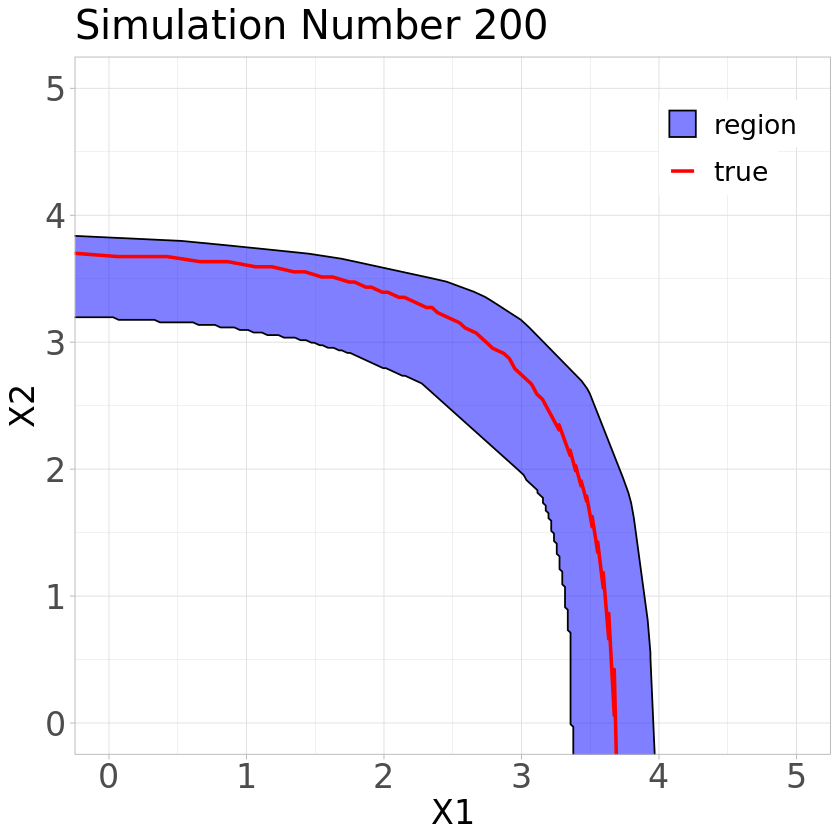

In [18]:
ggplot() + 
geom_polygon(data = data.frame(region_out$conf_region_poly[[1]]), aes(x = X1, y = X2, fill = 'region'), color = 'black', alpha = 0.5) + 
geom_line(data = isoline, aes(x = X1, y = X2, col = 'true'), size = 1) +
scale_fill_manual(values = c('region' = 'blue')) +
scale_color_manual(values = c('true' = 'red')) +
xlab('X1') + ylab('X2') +
ggtitle(paste0('Simulation Number ', index)) +
coord_cartesian(ylim=c(0, 5), xlim = c(0, 5)) +
theme_light() +
theme(legend.position = c(0.87, 0.87), 
      legend.title = element_blank(), 
#     legend.box.background = element_rect(colour = "black"), 
      axis.title = element_text(size = 20), 
      axis.text = element_text(size = 20), 
      legend.spacing.y = unit(0.002, 'cm'),
      text = element_text(size = 20))

In [19]:
setwd(paste0(path, '20000n_500B_500gticks_0.01pbase_beta0.0_bivt_confregs'))
files <- list.files()
bhats <- rep(0, length(files))

for (i in 1:length(files)) {
    
    bhats[i] <- readRDS(files[i])[[1]]$bhat
    
}

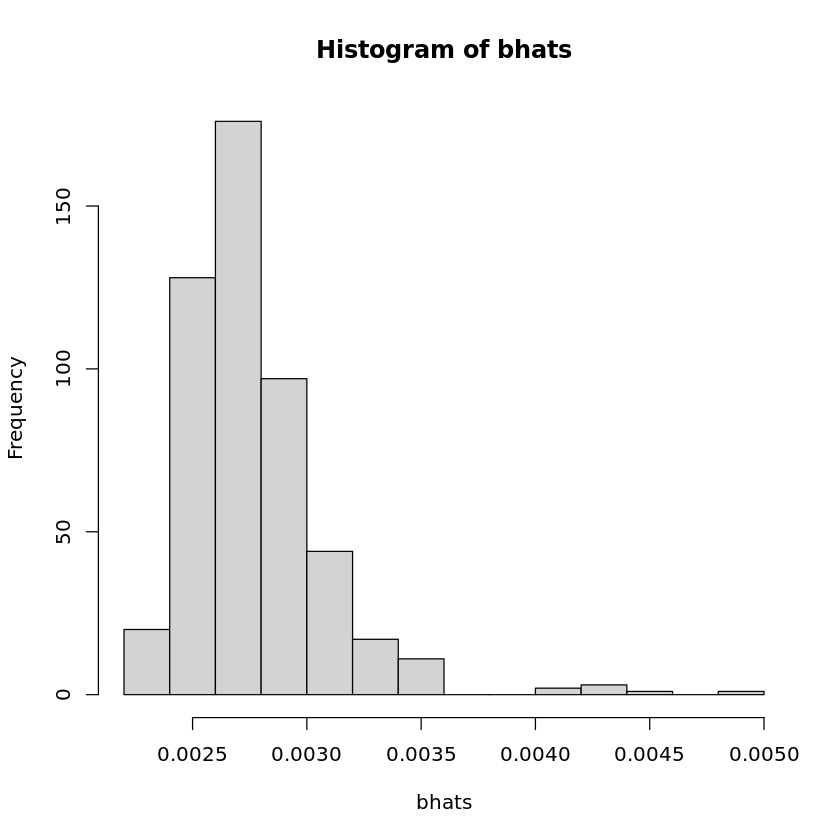

In [20]:
hist(bhats)

In [100]:
setwd(paste0(path, '15000n_500B_500gticks_0.01pbase_beta0.0_bivt_confregs'))
files <- list.files()
bhats <- rep(0, length(files))

for (i in 1:length(files)) {
    
    bhats[i] <- readRDS(files[i])[[1]]$bhat
    
}

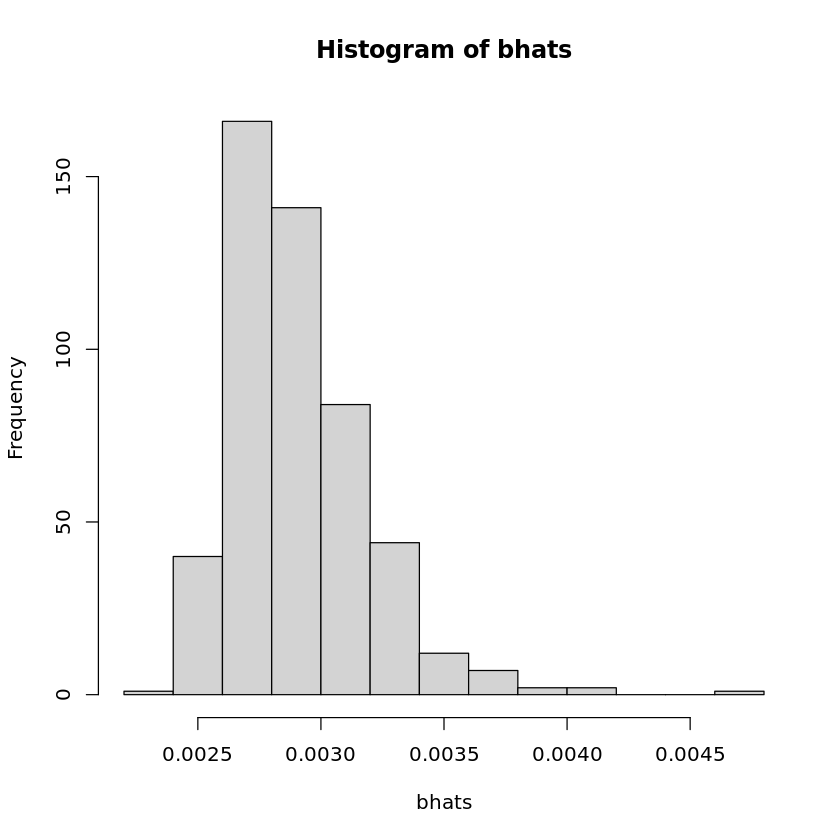

In [101]:
hist(bhats)

#### Att 3

+ projected grid 500 x 500
+ $\beta_{0} = 1 \times 10^{-6}$
+ empirical survival function grid 500 x 500
+ bootstrap survival function grid 100 x 100

In [54]:
path <- '/global/cscratch1/sd/jbbutler/sims/regions/gridsize_exp/bases_betazero6_gticks500/bgsize100_egsize500/'

In [55]:
# load up the base files to get base coverages

all_folders <- list.files(path=path)
specifiers <- c('beta0.0', 'bivt', '0.01pbase')
ns <- c()
covs <- c()
betas <- c()

for (i in 1:length(all_folders)) {
    
    folder <- all_folders[i]
    
    if (all(as.logical(lapply(specifiers, function(x) grepl(x, folder))))) {
        
        ns <- c(ns, as.numeric(gsub('.$', '', strsplit(folder, split = '_')[[1]][1])))
        
        files <- list.files(path = paste0(path, folder))
        
        setwd(paste0(path, folder))
        is_covered <- sapply(files, function(x){readRDS(x)[[3]]})
        beta <- sapply(files, function(x){readRDS(x)[[1]]$beta})
        cov <- sum(is_covered)/length(is_covered)
        covs <- c(covs, cov)
        betas <- c(betas, beta) 
            
    }
}

In [56]:
res_df <- data.frame(ns = ns, covs = covs)
res_df <- res_df[order(res_df$ns),]
res_df

,ns,covs
,<dbl>,<dbl>
1,20000,0.997992


In [26]:
setwd(paste0(path, '20000n_500B_500gticks_0.01pbase_beta0.000001_bivt_confregs'))
files <- list.files()
bhats <- rep(0, length(files))

for (i in 1:length(files)) {
    
    bhats[i] <- readRDS(files[i])[[1]]$bhat
    
}

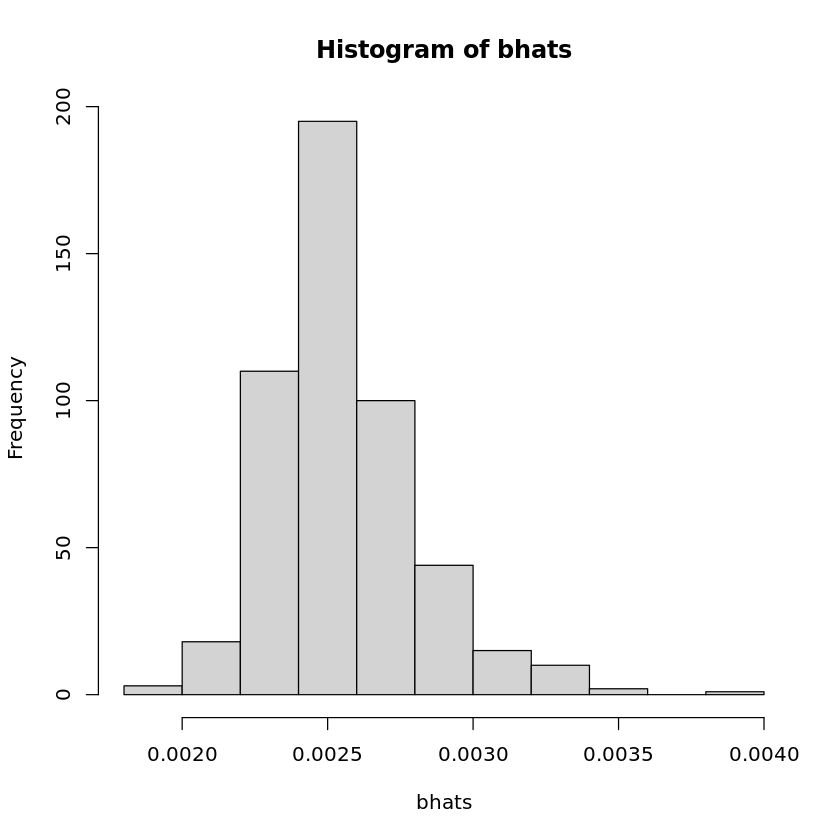

In [27]:
hist(bhats)

#### Att 4

+ projected grid 500 x 500
+ $\beta_{0} = 1 \times 10^{-6}$
+ empirical survival function grid 500 x 500
+ bootstrap survival function grid 500 x 500

In [57]:
path <- '/global/cscratch1/sd/jbbutler/sims/regions/gridsize_exp/bases_betazero6_gticks500/bgsize500_egsize500/'

In [58]:
# load up the base files to get base coverages

all_folders <- list.files(path=path)
specifiers <- c('beta0.0', 'bivt', '0.01pbase')
ns <- c()
covs <- c()
betas <- c()

for (i in 1:length(all_folders)) {
    
    folder <- all_folders[i]
    
    if (all(as.logical(lapply(specifiers, function(x) grepl(x, folder))))) {
        
        ns <- c(ns, as.numeric(gsub('.$', '', strsplit(folder, split = '_')[[1]][1])))
        
        files <- list.files(path = paste0(path, folder))
        
        setwd(paste0(path, folder))
        is_covered <- sapply(files, function(x){readRDS(x)[[3]]})
        beta <- sapply(files, function(x){readRDS(x)[[1]]$beta})
        cov <- sum(is_covered)/length(is_covered)
        covs <- c(covs, cov)
        betas <- c(betas, beta) 
            
    }
}

In [59]:
# plotting
res_df <- data.frame(ns = ns, covs = covs)
res_df <- res_df[order(res_df$ns),]
res_df

,ns,covs
,<dbl>,<dbl>
1,1000,0.8564356
2,20000,0.8316633


Seems like the coverage has dropped down! Yay! Let's look at the confidence regions to see what's going on..

In [30]:
setwd(paste0(path, '20000n_500B_500gticks_0.01pbase_beta0.000001_bivt_confregs'))
files <- list.files()
bhats <- rep(0, length(files))

for (i in 1:length(files)) {
    
    bhats[i] <- readRDS(files[i])[[1]]$bhat
    
}

Seems like with an increased bootstrap gridsize, the bhats are in general much smaller.. Would be interesting to observe the convergence rates for multiple $n$, and then see about the smooth vs. nonparametric bootstrap, as well as using an ecdf method instead (faster?), as well as my method to choose beta (see what the plots look like with this higher bootstrap grid size..) 

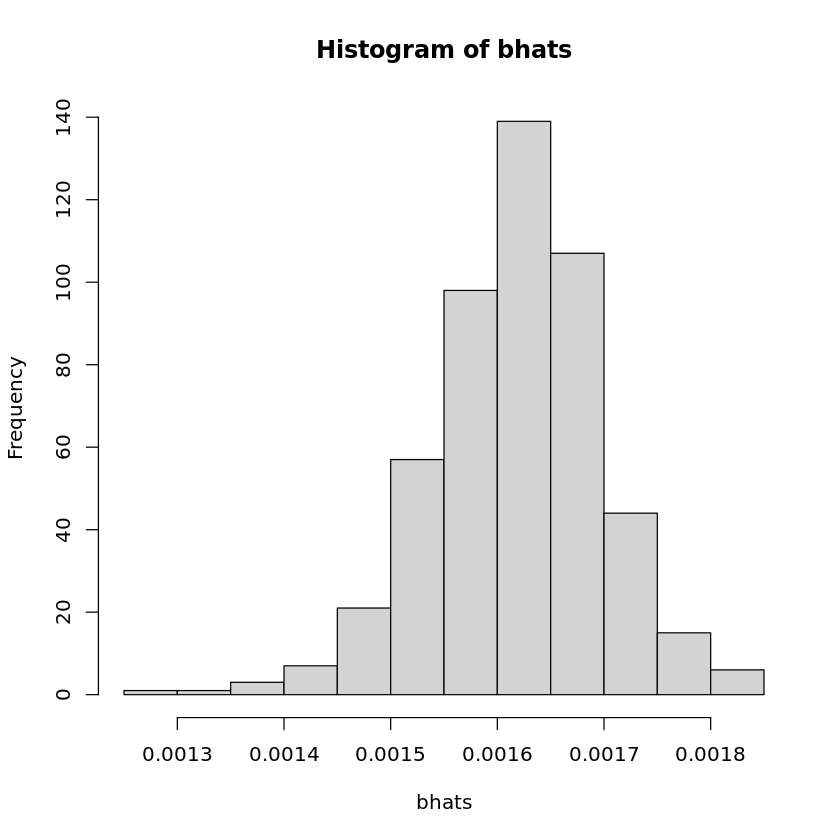

In [31]:
hist(bhats)

In [49]:
index <- 60

p <- 0.01
setwd(paste0(path, '20000n_500B_500gticks_0.01pbase_beta0.000001_bivt_confregs'))
files <- list.files()
region_out <- readRDS(files[index])[[1]]
isoline <- readRDS(paste0('/global/cscratch1/sd/jbbutler/isolines/bivariate_t/', p, '_bivt.RData'))

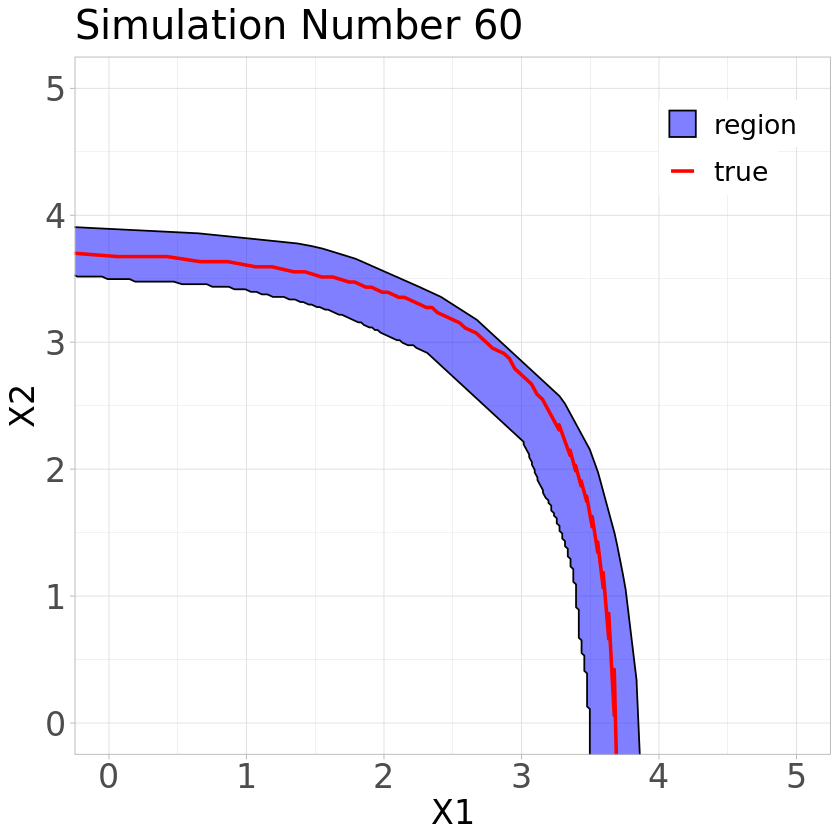

In [50]:
ggplot() + 
geom_polygon(data = data.frame(region_out$conf_region_poly[[1]]), aes(x = X1, y = X2, fill = 'region'), color = 'black', alpha = 0.5) + 
geom_line(data = isoline, aes(x = X1, y = X2, col = 'true'), size = 1) +
scale_fill_manual(values = c('region' = 'blue')) +
scale_color_manual(values = c('true' = 'red')) +
xlab('X1') + ylab('X2') +
ggtitle(paste0('Simulation Number ', index)) +
coord_cartesian(ylim=c(0, 5), xlim = c(0, 5)) +
theme_light() +
theme(legend.position = c(0.87, 0.87), 
      legend.title = element_blank(), 
#     legend.box.background = element_rect(colour = "black"), 
      axis.title = element_text(size = 20), 
      axis.text = element_text(size = 20), 
      legend.spacing.y = unit(0.002, 'cm'),
      text = element_text(size = 20))

For what it's worth, doesn't seem like it's super egregiously off either!

In [309]:
setwd(paste0(path, '1000n_500B_500gticks_0.01pbase_beta0.000001_bivt_confregs'))
files <- list.files()
bhats <- rep(0, length(files))

for (i in 1:length(files)) {
    
    bhats[i] <- readRDS(files[i])[[1]]$bhat
    
}

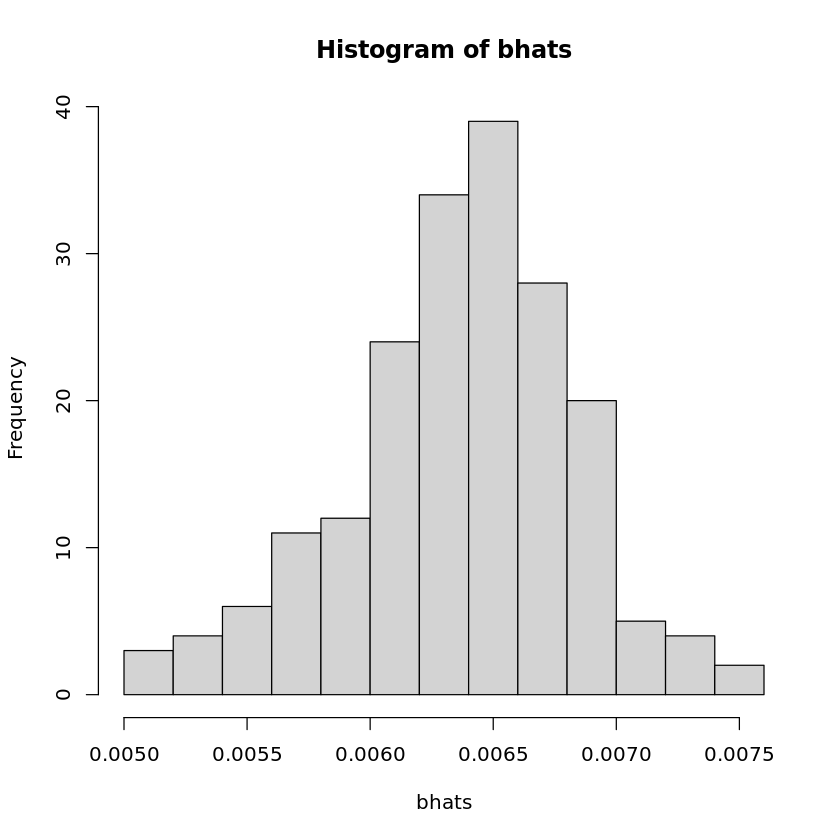

In [310]:
hist(bhats)

#### Att 5

+ projected grid 500 x 500
+ $\beta_{0} = 1 \times 10^{-6}$
+ empirical survival function grid 150 x 150
+ bootstrap survival function grid 150 x 150

In [60]:
path <- '/global/cscratch1/sd/jbbutler/sims/regions/gridsize_exp/bases_betazero6_gticks500/bgsize150_egsize150/'

In [61]:
all_folders <- list.files(path=path)
specifiers <- c('beta0.0', 'bivt', '0.01pbase')
ns <- c()
covs <- c()
betas <- c()

for (i in 1:length(all_folders)) {
    
    folder <- all_folders[i]
    
    if (all(as.logical(lapply(specifiers, function(x) grepl(x, folder))))) {
        
        ns <- c(ns, as.numeric(gsub('.$', '', strsplit(folder, split = '_')[[1]][1])))
        
        files <- list.files(path = paste0(path, folder))
        
        setwd(paste0(path, folder))
        is_covered <- sapply(files, function(x){readRDS(x)[[3]]})
        beta <- sapply(files, function(x){readRDS(x)[[1]]$beta})
        cov <- sum(is_covered)/length(is_covered)
        covs <- c(covs, cov)
        betas <- c(betas, beta) 
            
    }
}

In [88]:
index <- 70

p <- 0.01
setwd(paste0(path, '20000n_500B_500gticks_0.01pbase_beta0.000001_bivt_confregs'))
files <- list.files()
region_out <- readRDS(files[index])[[1]]
isoline <- readRDS(paste0('/global/cscratch1/sd/jbbutler/isolines/bivariate_t/', p, '_bivt.RData'))

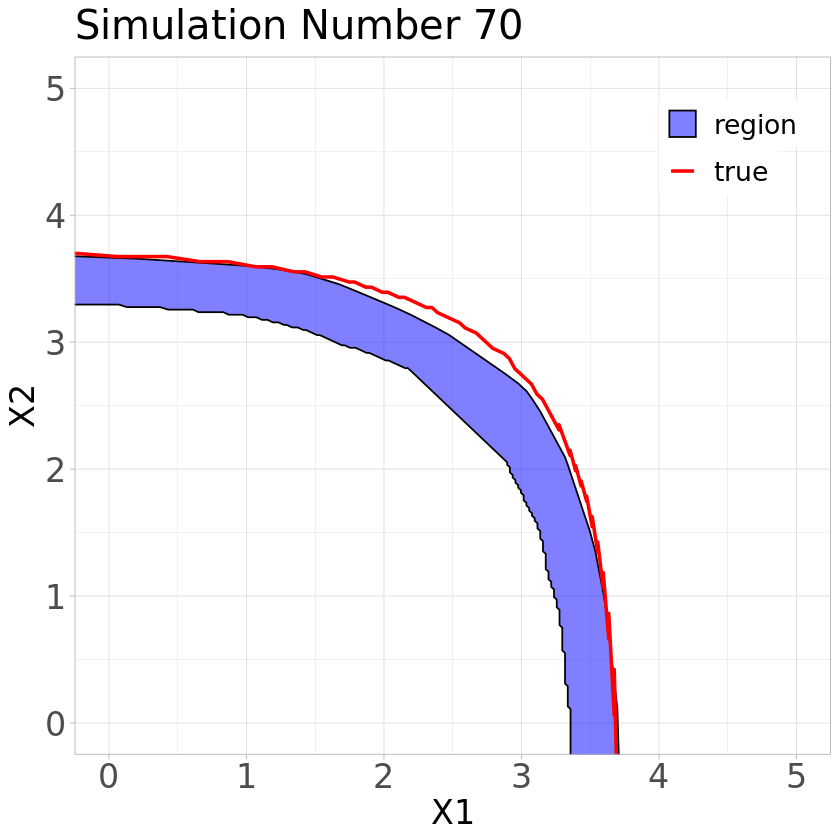

In [89]:
ggplot() + 
geom_polygon(data = data.frame(region_out$conf_region_poly[[1]]), aes(x = X1, y = X2, fill = 'region'), color = 'black', alpha = 0.5) + 
geom_line(data = isoline, aes(x = X1, y = X2, col = 'true'), size = 1) +
scale_fill_manual(values = c('region' = 'blue')) +
scale_color_manual(values = c('true' = 'red')) +
xlab('X1') + ylab('X2') +
ggtitle(paste0('Simulation Number ', index)) +
coord_cartesian(ylim=c(0, 5), xlim = c(0, 5)) +
theme_light() +
theme(legend.position = c(0.87, 0.87), 
      legend.title = element_blank(), 
#     legend.box.background = element_rect(colour = "black"), 
      axis.title = element_text(size = 20), 
      axis.text = element_text(size = 20), 
      legend.spacing.y = unit(0.002, 'cm'),
      text = element_text(size = 20))

The thing I've noticed before!! Downward bias..

In [77]:
res_df <- data.frame(ns = ns, covs = covs)
res_df <- res_df[order(res_df$ns),]
res_df

,ns,covs
,<dbl>,<dbl>
1,20000,0.45


#### Att 6

+ projected grid 250 x 250
+ $\beta_{0} = n^{-1/2}$
+ empirical survival function grid 500 x 500
+ bootstrap survival function grid 500 x 500

In [7]:
path <- '/global/cscratch1/sd/jbbutler/sims/regions/gridsize_exp/bases_betafunc0.5_gticks250/bgsize500_egsize500/'

In [8]:
all_folders <- list.files(path=path)
specifiers <- c('bivt', '0.01pbase')
ns <- c()
covs <- c()
betas <- c()

for (i in 1:length(all_folders)) {
    
    folder <- all_folders[i]
    
    if (all(as.logical(lapply(specifiers, function(x) grepl(x, folder))))) {
        
        ns <- c(ns, as.numeric(gsub('.$', '', strsplit(folder, split = '_')[[1]][1])))
        
        files <- list.files(path = paste0(path, folder))
        
        setwd(paste0(path, folder))
        is_covered <- sapply(files, function(x){readRDS(x)[[3]]})
        beta <- sapply(files, function(x){readRDS(x)[[1]]$beta})
        cov <- sum(is_covered)/length(is_covered)
        covs <- c(covs, cov)
        betas <- c(betas, beta) 
            
    }
}

In [16]:
covs

[1] 0.988

In [13]:
index <- 50

p <- 0.01
setwd(paste0(path, '20000n_500B_250gticks_500estgsize_500bootgsize_0.01pbase_0.5betafunc_bivt_confregs'))
files <- list.files()
region_out <- readRDS(files[index])[[1]]
isoline <- readRDS(paste0('/global/cscratch1/sd/jbbutler/isolines/bivariate_t/', p, '_bivt.RData'))

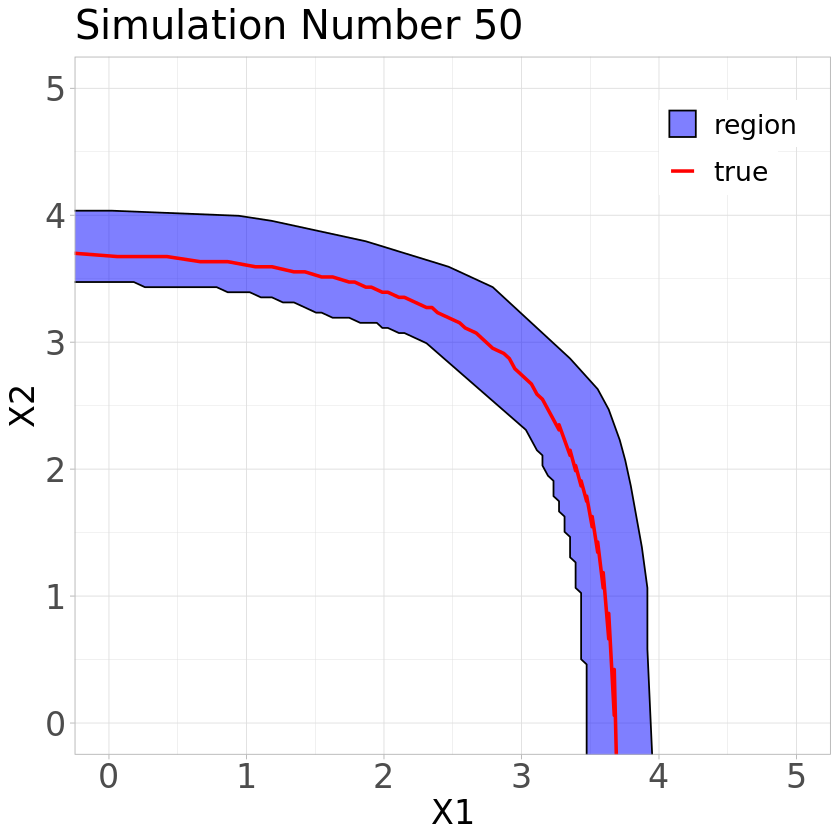

In [14]:
ggplot() + 
geom_polygon(data = data.frame(region_out$conf_region_poly[[1]]), aes(x = X1, y = X2, fill = 'region'), color = 'black', alpha = 0.5) + 
geom_line(data = isoline, aes(x = X1, y = X2, col = 'true'), size = 1) +
scale_fill_manual(values = c('region' = 'blue')) +
scale_color_manual(values = c('true' = 'red')) +
xlab('X1') + ylab('X2') +
ggtitle(paste0('Simulation Number ', index)) +
coord_cartesian(ylim=c(0, 5), xlim = c(0, 5)) +
theme_light() +
theme(legend.position = c(0.87, 0.87), 
      legend.title = element_blank(), 
#     legend.box.background = element_rect(colour = "black"), 
      axis.title = element_text(size = 20), 
      axis.text = element_text(size = 20), 
      legend.spacing.y = unit(0.002, 'cm'),
      text = element_text(size = 20))

#### Att 7

+ projected grid 150 x 150
+ $\beta_{0} = n^{-1/2}$
+ empirical survival function grid 500 x 500
+ bootstrap survival function grid 500 x 500

In [17]:
path <- '/global/cscratch1/sd/jbbutler/sims/regions/gridsize_exp/bases_betafunc0.5_gticks150/bgsize500_egsize500/'

In [18]:
all_folders <- list.files(path=path)
specifiers <- c('bivt', '0.01pbase')
ns <- c()
covs <- c()
betas <- c()

for (i in 1:length(all_folders)) {
    
    folder <- all_folders[i]
    
    if (all(as.logical(lapply(specifiers, function(x) grepl(x, folder))))) {
        
        ns <- c(ns, as.numeric(gsub('.$', '', strsplit(folder, split = '_')[[1]][1])))
        
        files <- list.files(path = paste0(path, folder))
        
        setwd(paste0(path, folder))
        is_covered <- sapply(files, function(x){readRDS(x)[[3]]})
        beta <- sapply(files, function(x){readRDS(x)[[1]]$beta})
        cov <- sum(is_covered)/length(is_covered)
        covs <- c(covs, cov)
        betas <- c(betas, beta) 
            
    }
}

In [19]:
covs

[1] 0.962

In [111]:
index <-120

p <- 0.01
setwd(paste0(path, '20000n_500B_150gticks_500estgsize_500bootgsize_0.01pbase_0.5betafunc_bivt_confregs'))
files <- list.files()
region_out <- readRDS(files[index])[[1]]
isoline <- readRDS(paste0('/global/cscratch1/sd/jbbutler/isolines/bivariate_t/', p, '_bivt.RData'))

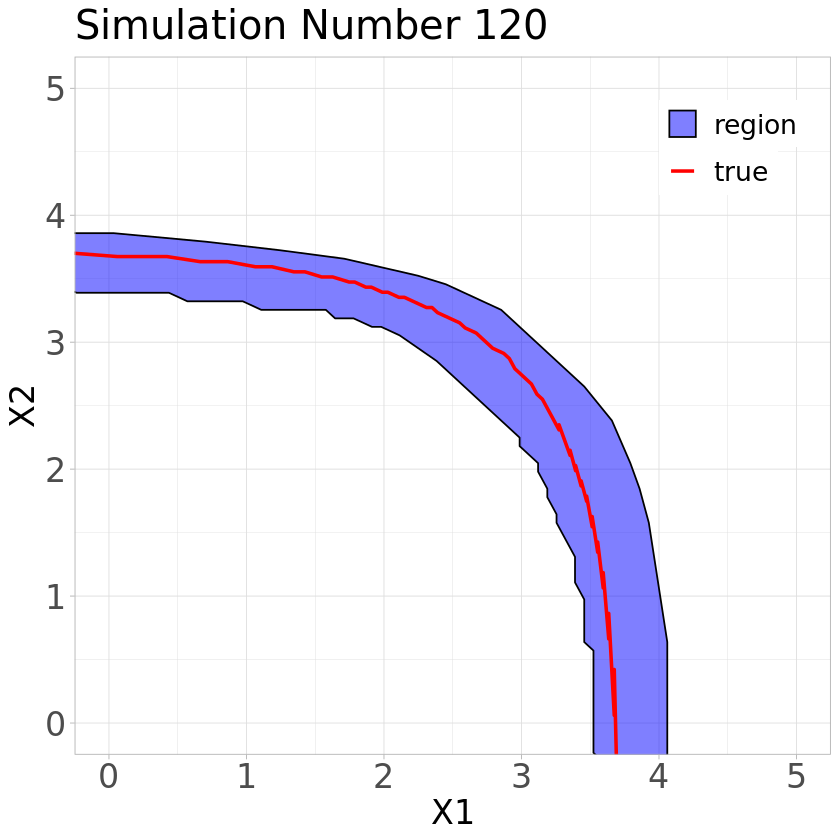

In [112]:
ggplot() + 
geom_polygon(data = data.frame(region_out$conf_region_poly[[1]]), aes(x = X1, y = X2, fill = 'region'), color = 'black', alpha = 0.5) + 
geom_line(data = isoline, aes(x = X1, y = X2, col = 'true'), size = 1) +
scale_fill_manual(values = c('region' = 'blue')) +
scale_color_manual(values = c('true' = 'red')) +
xlab('X1') + ylab('X2') +
ggtitle(paste0('Simulation Number ', index)) +
coord_cartesian(ylim=c(0, 5), xlim = c(0, 5)) +
theme_light() +
theme(legend.position = c(0.87, 0.87), 
      legend.title = element_blank(), 
#     legend.box.background = element_rect(colour = "black"), 
      axis.title = element_text(size = 20), 
      axis.text = element_text(size = 20), 
      legend.spacing.y = unit(0.002, 'cm'),
      text = element_text(size = 20))

In [99]:
a <- readRDS(files[1])

In [ ]:
a$base_out